# Gaussian Process on the Power Plant UCI dataset, using Inducing Points and all points

# Github

In [1]:
from google.colab import drive # For github
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Project18/GPs
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Mounted at /content/drive
/content/drive/MyDrive/Project18/GPs


# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install gpytorch
import gpytorch
from sklearn.model_selection import train_test_split
import math
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
%matplotlib inline
%load_ext autoreload
%autoreload 2
%run ../datasets/powerPlant.ipynb # Run the PowerPlant notebook which is in the datasets folder(PowerPlant dataset)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 9.2 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Project18/datasets
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB
None

AT    False
V     False
AP    False
RH    False
PE    False
dtype: bool


# Training/Test data from powerPlant.ipynb

In [25]:
# Set a seed for reproducibility
np.random.seed(52)

powerPlant_data = df_PowerPlant # df_PowerPlant is defined in ../datasets/powerPlant.ipynb
x, y = powerPlant_data.iloc[:, :-1].to_numpy() , powerPlant_data.iloc[:, -1].to_numpy()  # The last column is output(net hourly electrical energy output (EP)  of the plant)

# Split into training and validation datasets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.1)

# Standardize training input points
xTrain_mean = xTrain.mean(axis = 0) # mean for each feature
xTrain_std = xTrain.std(axis = 0) # std for each feature
xTrain_standardized = (xTrain-xTrain_mean) / xTrain_std # Standardize
# Standardize training output points
yTrain_mean = yTrain.mean(axis = 0) # mean
yTrain_std = yTrain.std(axis = 0) # std
yTrain_standardized = (yTrain-yTrain_mean) / yTrain_std # Standardize
yTrain_standardized_mean = yTrain_standardized.mean(axis = 0) # Mean after standardization

# Standardize test input points
xTest_mean = xTest.mean(axis = 0) # mean for each feature
xTest_std = xTest.std(axis = 0) # std for each feature
xTest_standardized = (xTest-xTest_mean) / xTest_std # Standardize
# Standardize test output points
yTest_mean = yTest.mean(axis = 0) # mean
yTest_std = yTest.std(axis = 0) # std
yTest_standardized = (yTest-yTest_mean) / yTest_std # Standardize
yTest_standardized_mean = yTest_standardized.mean(axis = 0) # Mean after standardization

# Convert them to tensors
xTrain_standardized = torch.from_numpy(xTrain_standardized).float()
yTrain_standardized = torch.from_numpy(yTrain_standardized).float()

xTest_standardized = torch.from_numpy(xTest_standardized).float()
yTest_standardized = torch.from_numpy(yTest_standardized).float()

print(xTrain_standardized.size(), yTrain_standardized.size(), xTest_standardized.size(), yTest_standardized.size())

torch.Size([8611, 4]) torch.Size([8611]) torch.Size([957, 4]) torch.Size([957])


# The GP model

In [26]:
# Class for the GP model(Exact GP)
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, x, y, likelihood):
        super(GPModel, self).__init__(x, y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # Decide which mean to use
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # Decide which kernel to use
    # GP Posterior predictive distribution
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the first model

In [27]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
model = GPModel(xTrain_standardized, yTrain_standardized, likelihood) # Use training points and given likelihood
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

# Training Function

In [28]:
import os
def train(model, xTrain, yTrain): # Train the model on training data: xTrain, yTrain
  smoke_test = ('CI' in os.environ)
  training_iter = 2 if smoke_test else 25

  # Find optimal model hyperparameters
  model.train()
  model.likelihood.train()

  # Use the adam optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
  # Train without printing to ensure the training method is as fast as possible
  for i in range(training_iter):
      # Zero gradients from previous iteration
      optimizer.zero_grad()
      # Output from model
      output = model(xTrain)
      # Calc loss and backprop gradients
      loss = -mll(output, yTrain)
      loss.backward()
      optimizer.step()


# Train the Model#

In [29]:
%time train(model, xTrain_standardized, yTrain_standardized) # 1h12min for 250 training iterations

CPU times: user 1min 19s, sys: 42.6 s, total: 2min 1s
Wall time: 2min 7s


# The posterior mean, variance and Covariance Matrix

In [30]:
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
  model.eval() # eval mode is for computing predictions through the model posterior
  f_preds = model(xTest_standardized) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y
  f_mean = f_preds.mean # Predictive mean
  f_var = f_preds.variance # Predictive variance
  f_covar = f_preds.covariance_matrix # Covariance matrix
  print("Mean Dimension: ", f_mean.size())
  print()
  print("Variance Dimension: ", f_var.size())
  print()
  print("CovMatrix Dimension ", f_covar.size())

Mean Dimension:  torch.Size([957])

Variance Dimension:  torch.Size([957])

CovMatrix Dimension  torch.Size([957, 957])


# Predictive Distribution

In [31]:
model.eval() # eval mode is for computing predictions through the model posterior.
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred = likelihood(f_preds)# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value
    prediction_means = observed_pred.mean.numpy()

# Compute Root Mean Square Error (RMSE)

In [32]:
squared_error = (prediction_means -  yTest_standardized.numpy())**2 # Compute the squared error

mean_SE = squared_error.mean() # Compute the mean squared error

root_MSE = math.sqrt(mean_SE) # Compute the square root of the mean squared error

print("Normalized RMSE: ", root_MSE)
# To transform the RMSE back to the original scale after normalization,
# you can simply multiply the RMSE by the standard deviation of the original output data and add the mean
print("RMSE: ", (root_MSE * yTest_std) + yTest_standardized_mean)

Normalized RMSE:  0.2542267170825853
RMSE:  4.257960540288673


# Calculate RMSE with original scales

In [33]:
meanTensor = torch.tensor(prediction_means) # Convert to tensor
predictions_original = ((meanTensor*yTest_std)+yTest_mean) # Transform to original scale

squared_error = (predictions_original -  yTest)**2 # Compute the squared error

mean_SE = squared_error.mean() # Compute the mean squared error

root_MSE = math.sqrt(mean_SE) # Compute the square root of the mean squared error

print("Normalized RMSE: ", root_MSE)

Normalized RMSE:  4.257960415387859


# Plot Predictions and Actual Output

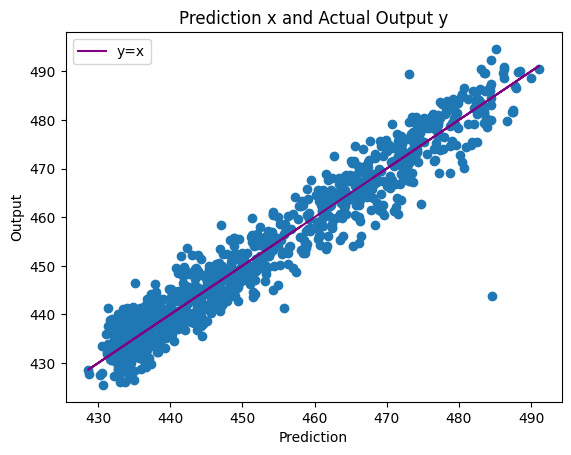

In [36]:
plt.scatter(predictions_original, yTest) # Transform predictions back to original scale
plt.plot(predictions_original, predictions_original, color = 'purple', label = 'y=x')
plt.title('Prediction x and Actual Output y')
plt.xlabel('Prediction')
plt.ylabel('Output')
plt.legend()
plt.show()

# Check for Overfitting, (RMSE of training data)

In [40]:
model.eval() # eval mode is for computing predictions through the model posterior.
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred_train = likelihood(model(xTrain_standardized))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value
    mean_train = observed_pred_train.mean.numpy()

squared_error_train = (mean_train - yTrain_standardized.numpy())**2 # Compute the squared error

mean_SE_train = squared_error_train.mean() # Compute the mean squared error

root_MSE_train = math.sqrt(mean_SE_train) # Compute the square root of the mean squared error

root_MSE_train

0.2335471792588511

# Compare different amount of points

In [45]:
# Trains models one by one for each amount of inducing points, and plots each model with plots [rows,columns](must match the length of listOfPoints)
def severalInducingPoints(listOfPoints):
  timeList = []
  for points in listOfPoints:
    inducingPointsX = torch.tensor(xTrain_standardized[:points]) # Choose how many points to pick
    inducingPointsY = torch.tensor(yTrain_standardized[:points]) # Choose how many points to pick
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
    model = GPModel(inducingPointsX, inducingPointsY, likelihood) # Send in inducing points as the training points
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    print()
    print("Inducing Points: ", points)

    time = %timeit -o train(model, inducingPointsX, inducingPointsY) # Train the model
    timeList.append(time.all_runs) # Add mean time of all runs for current amount of points
    # Plot
    model.eval() # eval mode is for computing predictions through the model posterior.
    likelihood.eval()
  return timeList
timeList = severalInducingPoints([100,200,300,400,500,600,700,800,900,1000])


<ipython-input-45-662a3fa204e7>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inducingPointsX = torch.tensor(xTrain_standardized[:points]) # Choose how many points to pick
<ipython-input-45-662a3fa204e7>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inducingPointsY = torch.tensor(yTrain_standardized[:points]) # Choose how many points to pick



Inducing Points:  100
143 ms ± 24.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Inducing Points:  200
173 ms ± 30.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Inducing Points:  300
331 ms ± 50.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  400
389 ms ± 7.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  500
1.09 s ± 459 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  600
1.37 s ± 411 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  700
1.47 s ± 313 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  800
1.86 s ± 287 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  900
1.07 s ± 182 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Inducing Points:  1000
1.28 s ± 245 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Plot The Different Times

([<matplotlib.axis.XTick at 0x79c6578ac880>,
 [Text(1, 0, '100'),
  Text(2, 0, '200'),
  Text(3, 0, '300'),
  Text(4, 0, '400'),
  Text(5, 0, '500'),
  Text(6, 0, '600'),
  Text(7, 0, '700'),
  Text(8, 0, '800'),
  Text(9, 0, '900'),
  Text(10, 0, '1000')])

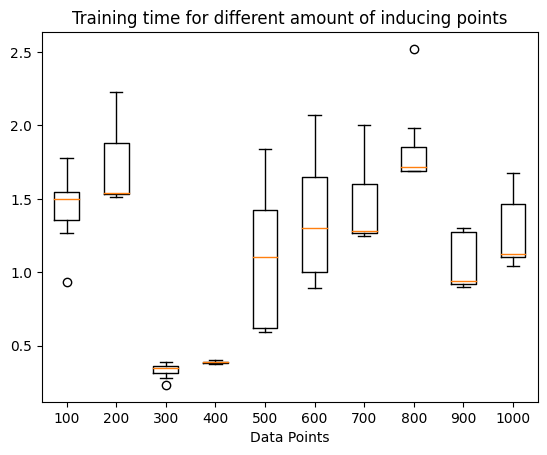

In [46]:
plt.title('Training time for different amount of inducing points')
plt.xlabel('Data Points')

plt.boxplot(timeList)
plt.xticks([1,2,3,4,5,6,7,8,9,10],[100,200,300,400,500,600,700,800,900,1000])

# Inducing Points with K-means

#K-means

In [41]:
def kmeansPoints(x, y, N): # The dataset (X,Y) and the N amount of inducing points wished
  RS = 0 # Random state
  kmeans = KMeans(n_clusters=N, n_init=1, random_state=RS ).fit(x) # Apply K-means clustering on the normalized training data
  xInducing = kmeans.cluster_centers_ # Use the centers of the clusters as the inducing points
  # To get the corresponding y values for each inducing point, compute the closest data point.
  closest_indices, _ = pairwise_distances_argmin_min(xInducing, x) # Will return indexes of xTrain_KMeans which is most similar(the same in this case) as xInducing
  yInducing = y[closest_indices] # Choose the corresponding y values for the inducing points
  return torch.from_numpy(xInducing).float(), yInducing

# Compare different amounts of inducing points
## Speed and Performance

In [74]:
# Trains models one by one for each amount of inducing points, and plots each model with plots [rows,columns](must match the length of listOfPoints)
def severalInducingPointsKmeans(listOfPoints):
  RMSE_list = []
  K_means_times = []
  train_times = []
  posterior_times = []
  for points in listOfPoints:
    print()
    print("Inducing Points: ", points)
    print("K-means:")
    time_Kmeans = %timeit -o kmeansPoints(xTrain_standardized, yTrain_standardized, points) # Time K-means
    K_means_times.append(time_Kmeans.average) # Append average time
    inducingPointsX, inducingPointsY = kmeansPoints(xTrain_standardized, yTrain_standardized, points) # Calculate Incucing Points

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
    model = GPModel(inducingPointsX, inducingPointsY, likelihood) # Send in inducing points as the training points
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    print("Training:")

    time_train = %timeit -o train(model, inducingPointsX, inducingPointsY) # Train the model
    train_times.append(time_train.average) # Append average time
    # Performance
    model.eval() # eval mode is for computing predictions through the model posterior.
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
      print("Predicitve Distribution:")
      time_posterior = %timeit -o likelihood(model(xTest_standardized)) # Time the posterior
      posterior_times.append(time_posterior.average) # Append average time
      observed_pred =  likelihood(model(xTest_standardized))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value
      mean = observed_pred.mean.numpy()

    squared_error = (mean - yTest_standardized.numpy())**2 # Compute the squared error
    mean_SE = squared_error.mean() # Compute the mean squared error
    root_MSE = math.sqrt(mean_SE) # Compute the square root of the mean squared error
    print("Normalized RMSE: ", root_MSE)
    RMSE = (root_MSE * yTest_std) + yTest_standardized_mean # Transform to original scale
    print("RMSE: ", RMSE)
    RMSE_list.append(RMSE) # Append to list of RMSE to plot later

  return RMSE_list, K_means_times, train_times, posterior_times # Return all lists for plotting

# Plot Training Times and Performance for different set of Inducing Points


Inducing Points:  5
K-means:
24.6 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Training:
78.9 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Predicitve Distribution:
2.08 ms ± 395 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Normalized RMSE:  0.5911084946142854
RMSE:  9.900283785985597

Inducing Points:  10
K-means:
93 ms ± 27.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Training:
101 ms ± 21.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Predicitve Distribution:
1.8 ms ± 56.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Normalized RMSE:  0.37809999950770123
RMSE:  6.332673830122948

Inducing Points:  15
K-means:
The slowest run took 5.47 times longer than the fastest. This could mean that an intermediate result is being cached.
123 ms ± 82.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Training:
The slowest run took 4.33 times longer than the fastest. This could mean that an intermedia

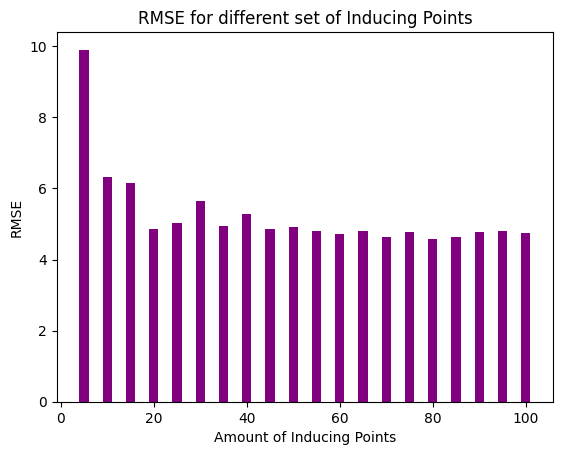

In [75]:
input1 = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
RMSE_list1, K_means_times1, train_times1, posterior_times1 = severalInducingPointsKmeans(input1)

plt.bar(input1, RMSE_list1, color ='purple',  width = 2)
plt.title('RMSE for different set of Inducing Points')
plt.xlabel('Amount of Inducing Points')
plt.ylabel('RMSE')
plt.show()

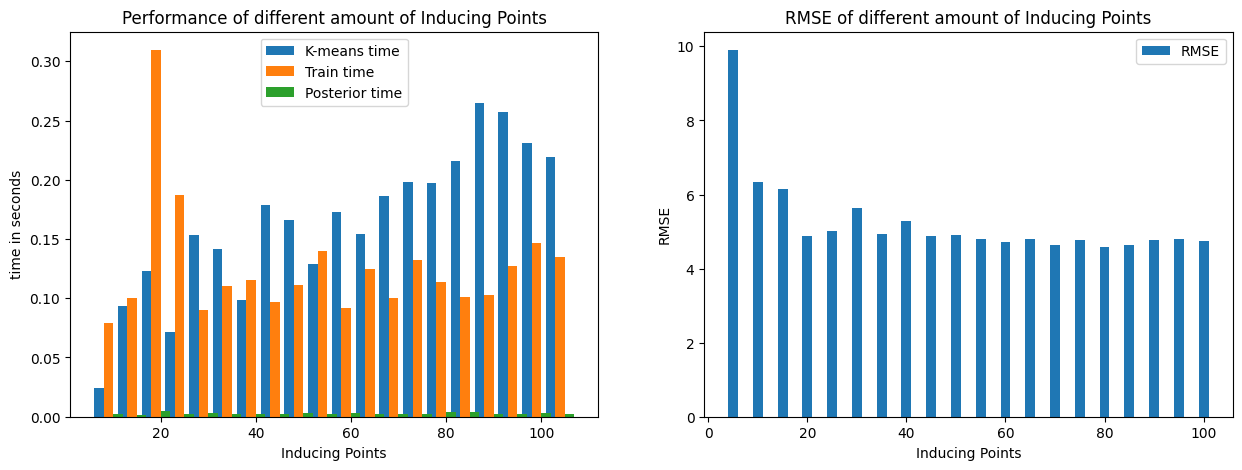

In [91]:
# Assuming the lists are of equal length
indices = np.array(input1)

# Width of a bar
width = 2

fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Create a figure and a 1x2 subplot

# First subplot
axs[0].bar(indices + width, K_means_times1, width, label='K-means time')
axs[0].bar(indices + 2*width, train_times1, width, label='Train time')
axs[0].bar(indices + 3*width, posterior_times1, width, label='Posterior time')

# Adding labels
axs[0].set_xlabel('Inducing Points')
axs[0].set_ylabel('time in seconds')
axs[0].set_title('Performance of different amount of Inducing Points')

# Adding legend
axs[0].legend()

# Second subplot
axs[1].bar(indices, RMSE_list1, width, label='RMSE')

# Adding labels
axs[1].set_xlabel('Inducing Points')
axs[1].set_ylabel('RMSE')
axs[1].set_title('RMSE of different amount of Inducing Points')

# Adding legend
axs[1].legend()

# Function to show the plot
plt.show()

# Larger sets of Inducing Points


Inducing Points:  1000
K-means:
CPU times: user 1.6 s, sys: 914 ms, total: 2.52 s
Wall time: 2.19 s
Training:
CPU times: user 1.15 s, sys: 2.83 ms, total: 1.15 s
Wall time: 1.15 s
Predicitve Distribution:
CPU times: user 114 ms, sys: 0 ns, total: 114 ms
Wall time: 122 ms
Normalized RMSE:  0.2618401374007703
RMSE:  4.385475239229354

Inducing Points:  2000
K-means:
CPU times: user 3.24 s, sys: 2.4 s, total: 5.65 s
Wall time: 5.01 s
Training:
CPU times: user 5.4 s, sys: 844 µs, total: 5.4 s
Wall time: 5.52 s
Predicitve Distribution:
CPU times: user 250 ms, sys: 0 ns, total: 250 ms
Wall time: 250 ms
Normalized RMSE:  0.25917986745475957
RMSE:  4.340919243751705

Inducing Points:  3000
K-means:
CPU times: user 4.2 s, sys: 2.2 s, total: 6.4 s
Wall time: 3.54 s
Training:
CPU times: user 10.1 s, sys: 3.66 s, total: 13.7 s
Wall time: 13.9 s
Predicitve Distribution:
CPU times: user 678 ms, sys: 1.82 ms, total: 679 ms
Wall time: 680 ms
Normalized RMSE:  0.2580090265007249
RMSE:  4.3213092096905

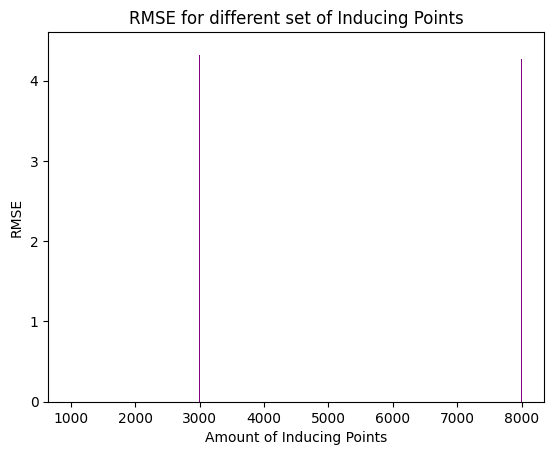

In [73]:
input2 = [1000,2000,3000,4000,5000,6000,7000,8000]

RMSE_list2, K_means_times2, train_times2, posterior_times2 = severalInducingPointsKmeans(input2)

plt.bar(input2, RMSE_list2, color ='purple',  width = 2)
plt.title('RMSE for different set of Inducing Points')
plt.xlabel('Amount of Inducing Points')
plt.ylabel('RMSE')
plt.show()